<a href="https://colab.research.google.com/github/Brymer-Meneses/PyTorch-Basics/blob/master/PyTorch_CvD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [182]:
import torch
import torchvision
from torchvision import transforms
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.autograd import Variable


import pandas as pd
import os
from zipfile import ZipFile
from skimage import io

import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/External Datasets/Kaggle"

In [3]:
!kaggle competitions download -c dogs-vs-cats

 91% 248M/271M [00:03<00:00, 62.0MB/s]
100% 271M/271M [00:04<00:00, 70.8MB/s]
 96% 524M/543M [00:07<00:00, 61.1MB/s]
100% 543M/543M [00:07<00:00, 73.3MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 83.6MB/s]


In [4]:
zip_path = '/content/train.zip'

zip = ZipFile(zip_path, 'r')
zip.extractall()

In [5]:
data = os.listdir('/content/train')
ds = pd.DataFrame()
ds['file'] = data

In [170]:
def classify(img):
  if img.split('.')[0] == 'dog':
    return 1
  elif img.split('.')[0] == 'cat':
    return 0

In [7]:
ds['target'] = list(map(classify, ds['file']))

In [8]:
ds.to_csv(r'/content/train.csv', index = False, header = False)

In [73]:
# DataLoader

class CatsAndDogsDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform = None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations) 
  
  def __getitem__(self, index):
   
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)
    y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

    if self.transform:
      image = self.transform(image)
    
    return (image, y_label)


In [218]:
T = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(255),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

In [219]:


dataset = CatsAndDogsDataset(csv_file = '/content/train.csv',
                             root_dir = '/content/train', 
                             transform = T
                            )

In [220]:
def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title == 1:
      plt.title("dog")
    else:
      plt.title('cat')
    plt.show()


In [221]:
dataiter = iter(dataset)

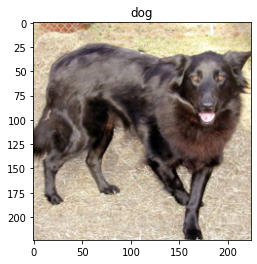

In [227]:
img, label = next(dataiter)
imshow(img, label)

In [228]:
train_set , test_set = torch.utils.data.random_split(dataset, [20000, 4999])

In [229]:
train_loader = DataLoader(dataset = train_set, batch_size = 64, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = 64, shuffle = False)

# Create Neural Network

In [235]:
# nn_out = floor((n_in + 2p - k)/s) + 1

In [248]:
labels = ['cat', 'dog']

in_size = 3
hid1_size = 16
hid2_size = 32
out_size = len(labels)
k_conv_size = 5 

class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size ),
            nn.BatchNorm2d(hid1_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, k_conv_size),
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

        self.fc = nn.Linear(hid2_size *  k_conv_size * k_conv_size, out_size)

    def forward(self, x):

        out = self.layer1(x)
        print(out.shape)
        out = self.layer2(out)
        print(out.shape)
        out = out.reshape(out.size(0), -1)
        print(out.shape)
        out = self.fc(out)

        return out



In [249]:
model = ConvNet()

In [250]:
# HyperParameters
n_epochs = 10
lr = 0.001


In [251]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, momentum=0.9)

In [252]:
losses = []
for e in range(n_epochs):
  counter = 0
  for i, (images, labels) in enumerate(train_loader):
    images = Variable(images)
    labels = Variable(labels)
    output = model(images)

    model.zero_grad()
    loss = cec_loss(output, labels)
    loss.backward()

    optimizer.step()
    n_iterations +=1 
    counter += 1

    if counter % 100 == 0:
      print(loss.item())

torch.Size([64, 16, 110, 110])
torch.Size([64, 32, 53, 53])
torch.Size([64, 89888])


RuntimeError: ignored